In [62]:
from myLibrary.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, spearmanr
from statsmodels.tsa.arima.model import ARIMA
from scipy.optimize import minimize 
import scipy

# Problem 1

details in pass_tests.py in Week05/Project

# Problem 2

In [63]:
Stock_prices = pd.read_csv('Problem1.csv')
Stock = Stock_prices['x']

In [64]:
def exp_weighted_cov(returns, lambda_):  
    # Preprocess the data
    returns = returns.values
    
    # Initializing the covariance matrix
    n_timesteps = returns.shape[0]
    Var = np.cov(returns, rowvar=False)
    
    # Updating the covariance matrix
    for t in range(1, n_timesteps):
        Var = lambda_ * Var + (1 - lambda_) * np.outer(returns[t], returns[t])
    return Var

In [65]:
def calculate_var_ew_normal(returns, lambda_=0.97, num_simulations=10000, alpha=0.05):
    """Calculate VaR and ES using a normal distribution with exponentially weighted variance"""
    mu = returns.mean()
    sigma = np.sqrt(exp_weighted_cov(returns, lambda_=lambda_))
    sim_returns = np.random.normal(mu, sigma[0][0], num_simulations)
    var_ew = -np.percentile(sim_returns, alpha*100)
    es_ew = -np.mean(sim_returns[sim_returns <= -var_ew])
    return var_ew, es_ew, sim_returns

In [66]:
def MLE_T(params, returns):
    negLL = -1 * np.sum(t.logpdf(returns, df=params[0], loc=params[1], scale=params[2]))
    return(negLL)

In [67]:
def calculate_var_t_MLE(returns, num_simulations=10000, alpha=0.05):
    """Calculate VaR using a T-distribution with MLE fitted degrees of freedom"""
    constraints=({"type":"ineq", "fun":lambda x: x[0]-1}, {"type":"ineq", "fun":lambda x: x[2]})
    returns_t = minimize(MLE_T, x0=[10, np.mean(returns), np.std(returns)], args=returns, constraints=constraints)
    df, loc, scale = returns_t.x[0], returns_t.x[1], returns_t.x[2]
    sim_returns = t.rvs(df, loc=loc, scale=scale, size=num_simulations)
    var_t = -np.percentile(sim_returns, alpha*100)
    es_t = -np.mean(sim_returns[sim_returns <= -var_t])
    return var_t, es_t, sim_returns

In [68]:
def calculate_var_hist(returns, alpha=0.05):
    """Calculate VaR using historic simulation"""
    var_hist = -np.percentile(returns, alpha*100)
    es_h = -np.mean(returns[returns <= -var_hist])
    return var_hist,es_h, returns

In [69]:
def plot_histogram_with_var_and_es(series, var, es, title):
    plt.hist(series, bins=80, density=True, alpha=0.5, color='skyblue')
    sns.kdeplot(series, color='green', linewidth=1)
    
    x_var = np.linspace(np.min(series), -var, 1000)
    y_var = scipy.stats.norm.pdf(x_var, np.mean(series), np.std(series))
    plt.fill_between(x_var, y_var, color='lightgrey', label='Range until VaR')
    
    x_es = np.linspace(np.min(series), -es, 1000)
    y_es = scipy.stats.norm.pdf(x_es, np.mean(series), np.std(series))
    plt.fill_between(x_es, y_es, color='red', alpha=0.3, label='Conditional Value at Risk')
    
    plt.axvline(0, color='green', linestyle='--', linewidth=1)
    plt.axvline(-var, color='blue', linestyle='-', linewidth=1, label='VaR')
    plt.axvline(-es, color='red', linestyle='-', linewidth=1, label='ES')
    
    plt.title(title + '\nVaR = {:.6f}, ES = {:.6f}'.format(var, es))
    plt.legend()
    plt.show()

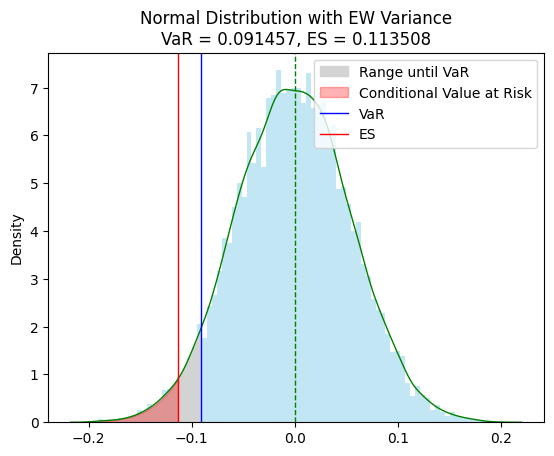

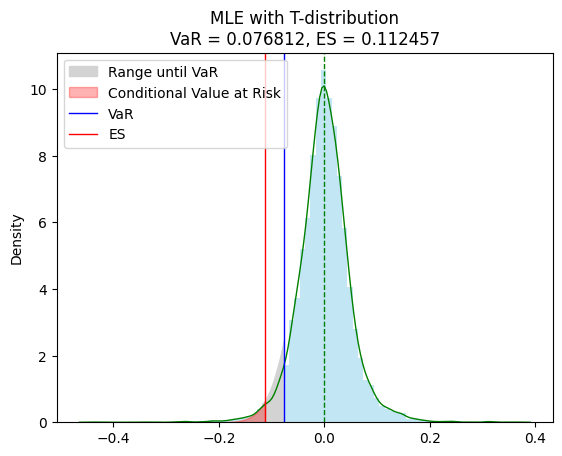

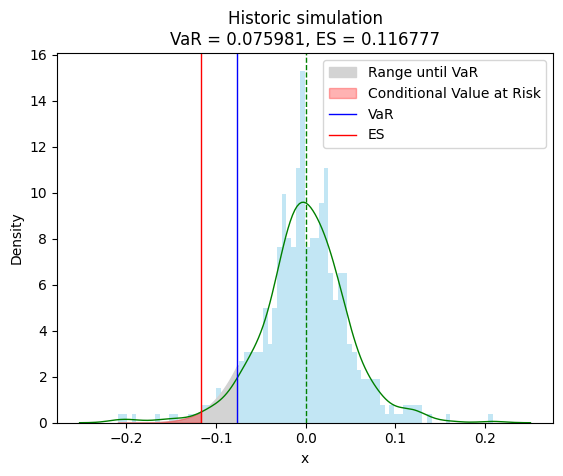

In [70]:
var_ew, es_ew, returns_ew = calculate_var_ew_normal(Stock)
plot_histogram_with_var_and_es(returns_ew, var_ew, es_ew,"Normal Distribution with EW Variance")

var_t, es_t,returns_t = calculate_var_t_MLE(Stock)
plot_histogram_with_var_and_es(returns_t, var_t, es_t, "MLE with T-distribution")

var_hist, es_h, returns_hist = calculate_var_hist(Stock)
plot_histogram_with_var_and_es(returns_hist, var_hist, es_h,  "Historic simulation")

# Problem 3

In [71]:
def calculate_uSim(U, nSim):
    spcor = spearmanr(U, axis = 0)[0]
    uSim = multivariate_normal_simulation(spcor, nSim,method = 'pca')
    uSim = norm.cdf(uSim,loc=0,scale=1)
    return uSim

In [72]:
def calculate_portfolio_VaR_ES(portfolio_name, prices, portfolio_info, nSim=1000, model='t'):
    # Calculate returns for all stocks
    returns_all = return_calculate(prices)
    # Center returns
    returns_all.iloc[:, 1:] = returns_all.iloc[:, 1:].apply(lambda x: x - x.mean(), axis=0)
    # Drop 'Date' column
    returns_all.drop('Date', axis=1, inplace=True)

    # Determine stocks based on portfolio
    if portfolio_name.upper() == 'ALL':
        portfolio_holding = portfolio_info.loc[:, ['Stock', 'Holding']]
        stocks = portfolio_info['Stock']
    else:
        portfolio_holding = portfolio_info[portfolio_info['Portfolio'] == portfolio_name].loc[:, ['Stock', 'Holding']]
        stocks = portfolio_info[portfolio_info['Portfolio'] == portfolio_name]['Stock']
    
    # Get current prices
    current_prices = prices.loc[:, stocks].tail(1)
    stocks = stocks.reset_index(drop=True)

    # Fit models to the returns
    fittedModel = {stock: fit_t(returns_all[stock]) if model == 't' else fit_normal(returns_all[stock]) for stock in stocks}
    U = pd.DataFrame()

    # Calculate cumulative distribution function values based on the model
    if model == 't':
        for stock, arg in fittedModel.items():
            stock_return = returns_all[stock]
            df, loc, scale = arg
            U[stock] = t.cdf(stock_return, df, loc, scale)
    elif model == 'normal':
        for stock, arg in fittedModel.items():
            stock_return = returns_all[stock]
            mu, sigma = arg
            U[stock] = norm.cdf(stock_return, mu, sigma)

    # Calculate uSim
    uSim = calculate_uSim(U, nSim)
    simulatedReturns = pd.DataFrame()

    # Calculate inverse cumulative distribution function values based on the model
    if model == 't':
        for i in range(uSim.shape[1]):
            stock_name = stocks[i]
            df, loc, scale = fittedModel[stock_name]
            simulatedReturns[stock_name] = t.ppf(uSim[:, i], df, loc, scale)
    elif model == 'normal':
        for i in range(uSim.shape[1]):
            stock_name = stocks[i]
            mu, sigma = fittedModel[stock_name]
            simulatedReturns[stock_name] = norm.ppf(uSim[:, i], mu, sigma)

    # Calculate simulated prices and holdings
    sim_prices = simulatedReturns.mul(current_prices.values.reshape(-1), axis=1)
    sim_holdings = sim_prices.dot(portfolio_holding['Holding'].values.reshape(-1, 1))

    # Merge portfolio holding and iteration data
    iterations = pd.DataFrame({'iteration': [i for i in range(1, nSim + 1)]})
    values = pd.merge(portfolio_holding, iterations, how='cross')

    nv = len(values)  # Number of rows in the DataFrame
    simulatedValue = [0] * nv  # Initialize a list with zeros for simulated values
    pnl = [0] * nv  # Initialize a list with zeros for profit and loss

    # Calculate simulated values and P&L
    for i in range(nv):
        iteration_raw = values.iloc[i]['iteration']
        iteration = (iteration_raw % nSim) if iteration_raw == nSim else iteration_raw  # Reset iteration after reaching the maximum
        stock = values.iloc[i]['Stock']
        price = prices.loc[0, stock]
        currentValue = values.iloc[i]['Holding'] * price

        ret = simulatedReturns.loc[iteration, stock]
        simulatedValue[i] = currentValue * (1 + ret)
        pnl[i] = simulatedValue[i] - currentValue

    # Add P&L and simulated value columns to the DataFrame
    values['pnl'] = pnl
    values['simulatedValue'] = simulatedValue

    # Aggregate P&L values by iteration
    pnl_sum = values.groupby('iteration').agg({'pnl': 'sum'}).reset_index()['pnl']

    # Calculate VaR and ES based on the model
    if model == 't':
        Var = VaR_t(fit_t(pnl_sum)[0], fit_t(pnl_sum)[1], fit_t(pnl_sum)[2], alpha=0.05)
        ES = ES_t(fit_t(pnl_sum)[0], fit_t(pnl_sum)[1], fit_t(pnl_sum)[2], alpha=0.05)
    if model == 'normal':
        mu, sigma = fit_normal(pnl_sum)
        Var = VaR_norm(mu, sigma, alpha=0.05)
        ES = ES_norm(mu, sigma, alpha=0.05)

    return Var, ES, sim_holdings


In [73]:
def plot_portfolio_var_es(sim_prices, VaR_T, ES_T, title):
    plt.hist(sim_prices, bins=80, density=True, alpha=0.5, color='skyblue')
    sns.kdeplot(sim_prices, color='green', linewidth=1)
    plt.axvline(0, color='green', linestyle='--', linewidth=1)
    plt.axvline(-VaR_T, color='blue', linestyle='-', label='VaR')
    plt.axvline(-ES_T, color='r', linestyle='-', label='ES')
    
    plt.title(title + '\nVaR = {:.6f}, ES = {:.6f}'.format(VaR_T, ES_T))
    plt.legend()
    plt.show()
        
    print("For {}," .format(title))
    print("VaR is {}" .format(VaR_T))
    print("ES is {}" .format(ES_T))

In [74]:
prices = pd.read_csv('DailyPrices.csv')
portfolio = pd.read_csv("portfolio.csv")

-172889.5187076628
-539.6677859790061


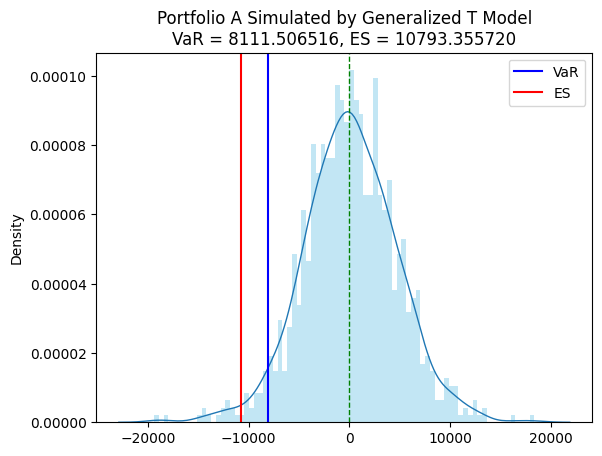

For Portfolio A Simulated by Generalized T Model,
VaR is 8111.506515951895
ES is 10793.355719580122
-64325.30182776498
-448.35259286342773


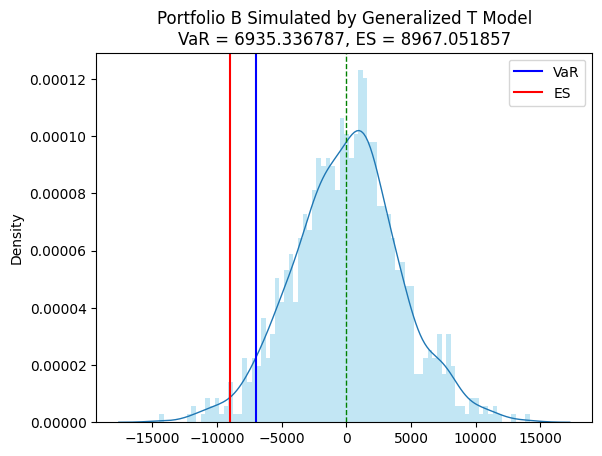

For Portfolio B Simulated by Generalized T Model,
VaR is 6935.336786880258
ES is 8967.051857268554
-26693.540430254187
-394.25429009496946


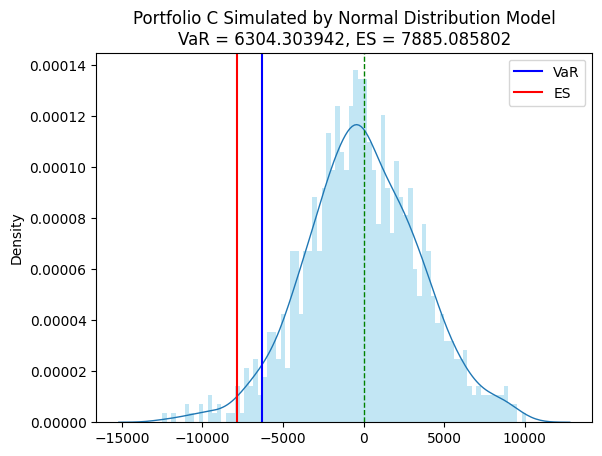

For Portfolio C Simulated by Normal Distribution Model,
VaR is 6304.303942182398
ES is 7885.085801899389
-263574.26476536633
-1445.0925745207755


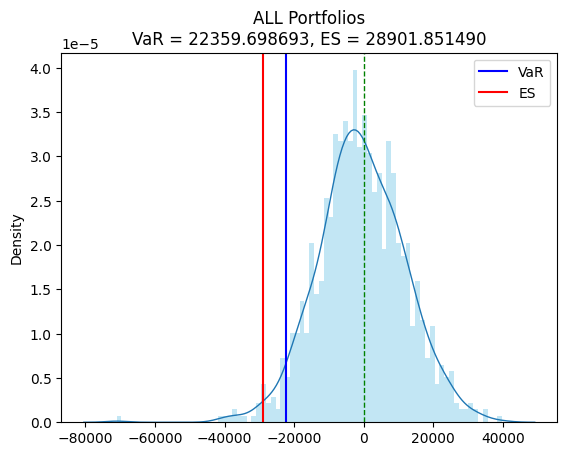

For ALL Portfolios,
VaR is 22359.698692799026
ES is 28901.85149041551


In [75]:
var_A, es_A, sim_prices_A= calculate_portfolio_VaR_ES('A', prices, portfolio)
plot_portfolio_var_es(sim_prices_A,var_A, es_A,'Portfolio A Simulated by Generalized T Model')
var_B, es_B, sim_prices_B = calculate_portfolio_VaR_ES('B', prices, portfolio)
plot_portfolio_var_es(sim_prices_B,var_B, es_B,'Portfolio B Simulated by Generalized T Model')
var_C, es_C, sim_prices_C = calculate_portfolio_VaR_ES('C', prices, portfolio, model ='normal')
plot_portfolio_var_es(sim_prices_C,var_C, es_C,'Portfolio C Simulated by Normal Distribution Model')
var_All, es_All, sim_prices_All = calculate_portfolio_VaR_ES('ALL', prices, portfolio)
plot_portfolio_var_es(sim_prices_All,var_All, es_All,'ALL Portfolios')